## Tal Sharoni, Justin Lipper

### Phys-321 Final Project

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from astropy import units as u
from astropy.visualization import astropy_mpl_style
from scipy.integrate import trapz
import scipy.stats as stats
from scipy.optimize import curve_fit
import corner
import emcee
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# to compare to our Solar System
radius = [0.383, 0.949, 1, 0.532, 11.21, 9.45, 4.01, 3.88]
stallar_rad = 1
a = [0.387, 0.723, 1, 1.52, 5.20, 9.57, 19.17, 30.18]

In [3]:
def parse_data(filename):
    radius = []
    stallar_rad = []
    orbital_period = []
    orbit_sma = []
    with open(filename, 'r') as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            if row[0].startswith('#'):
                continue
            if row[0] == 'pl_name':
                continue
            else:
                if (row[21] == '') or (row[26] == '') or (row[19] == '') or (row[20] == ''):
                    continue
                radius.append(float(row[21]))
                stallar_rad.append(float(row[26]))
                orbital_period.append(float(row[19]))
                orbit_sma.append(float(row[20]))
    return radius, stallar_rad, orbital_period, orbit_sma            

In [4]:
radius, stallar_rad, orbital_period, orbit_sma = parse_data('./PSCompPars_2024.03.30_12.22.56.csv')

First, we would like to create a likelihood model for the data, we will do so by fitting the distribution of all the parameters. We can start by plotting histograms of each parameter, and fitting a function to it. Some x domains will be cut off since there are significant outliers with extreme data, and we would like to see the trends of the distributions but those outliers will still be considered for later in the data analysis. Some of the data was also filtered to be able to bin it appropriately. The fitted fuction will be used as likelihood functions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


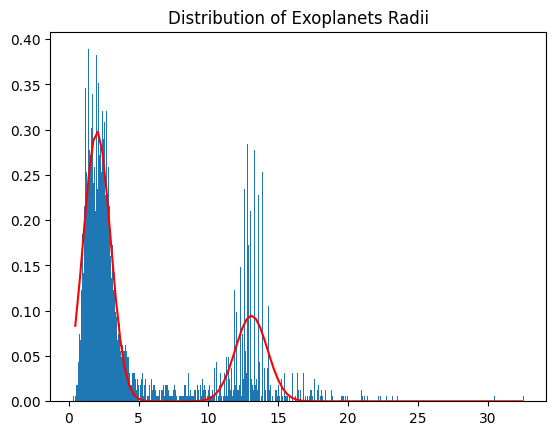

In [13]:
plt.hist(radius, bins=1000, density=True);
plt.title('Distribution of Exoplanets Radii')
def bimodal(x, mu1, sigma1, mu2, sigma2, w1):
    return (w1 * (1 / np.sqrt(2 * np.pi * sigma1**2)) * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
            + (1 - w1) * (1 / np.sqrt(2 * np.pi * sigma2**2)) * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

hist, bins = np.histogram(radius, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [2, 2, 8, 12, 0.5]
popt, pcov = curve_fit(bimodal, bin_centers, hist, p0=initial_guess)
plt.plot(bin_centers, bimodal(bin_centers, *popt), 'r-', label='Fit')

[  0.55725   1.65175   2.74625   3.84075   4.93525   6.02975   7.12425
   8.21875   9.31325  10.40775  11.50225  12.59675  13.69125  14.78575
  15.88025  16.97475  18.06925  19.16375  20.25825  21.35275  22.44725
  23.54175  24.63625  25.73075  26.82525  27.91975  29.01425  30.10875
  31.20325  32.29775  33.39225  34.48675  35.58125  36.67575  37.77025
  38.86475  39.95925  41.05375  42.14825  43.24275  44.33725  45.43175
  46.52625  47.62075  48.71525  49.80975  50.90425  51.99875  53.09325
  54.18775  55.28225  56.37675  57.47125  58.56575  59.66025  60.75475
  61.84925  62.94375  64.03825  65.13275  66.22725  67.32175  68.41625
  69.51075  70.60525  71.69975  72.79425  73.88875  74.98325  76.07775
  77.17225  78.26675  79.36125  80.45575  81.55025  82.64475  83.73925
  84.83375  85.92825  87.02275  88.11725  89.21175  90.30625  91.40075
  92.49525  93.58975  94.68425  95.77875  96.87325  97.96775  99.06225
 100.15675 101.25125 102.34575 103.44025 104.53475 105.62925 106.72375
 107.8

Text(0.5, 1.0, 'Distribution of Exoplanets Staller Radii, Cut Domain')

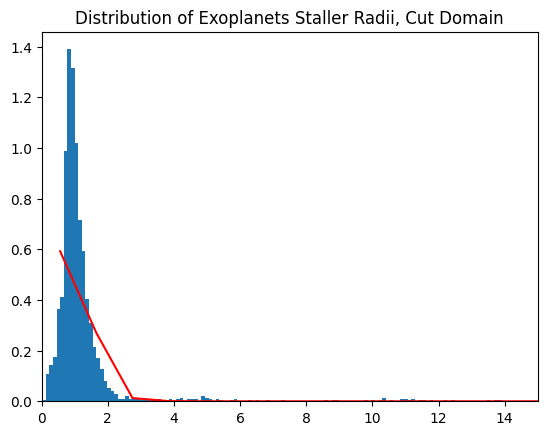

In [23]:
plt.hist(stallar_rad, bins=1000, density=True);
plt.xlim(0, 15)

def lognormal(x, m, sigma):
    return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))

hist, bins = np.histogram(stallar_rad, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 1]
print(bin_centers)
popt, pcov = curve_fit(lognormal, bin_centers, hist, p0=initial_guess)
plt.plot(bin_centers, lognormal(bin_centers, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Staller Radii, Cut Domain')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_94276/260465062.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Orbital Period, After Filtering')

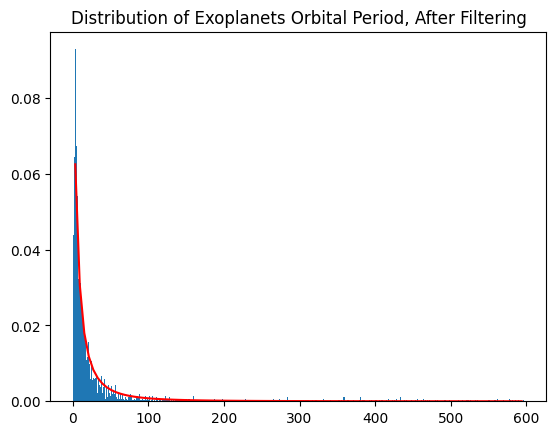

In [24]:
filtered_orbital_period = [value for value in orbital_period if value < 600]
plt.hist(filtered_orbital_period, bins=1000, density=True);


hist, bins = np.histogram(filtered_orbital_period, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers, hist, p0=initial_guess)
plt.plot(bin_centers, lognormal(bin_centers, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Orbital Period, After Filtering')

/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_94276/260465062.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Semi Major Axis, After Filtering')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


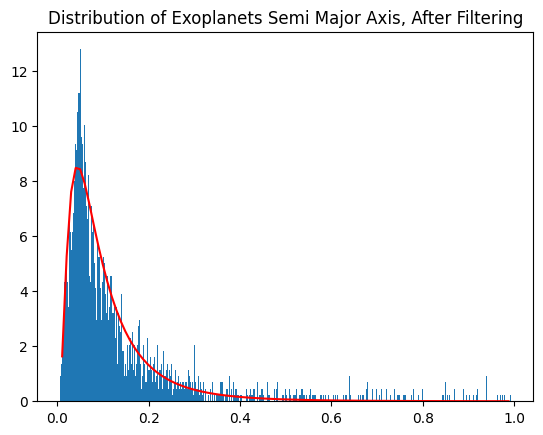

In [25]:
filtered_sma = [value for value in orbit_sma if value < 1]
plt.hist(filtered_sma, bins=1000, density=True);

hist, bins = np.histogram(filtered_sma, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers, hist, p0=initial_guess)
plt.plot(bin_centers, lognormal(bin_centers, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Semi Major Axis, After Filtering')